In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from autogluon.tabular import TabularDataset, TabularPredictor
from scipy.stats import chi2_contingency

from countryinfo import CountryInfo
from geopy.distance import geodesic

/opt/anaconda3/envs/data/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('dataset/Lead Scoring.csv')
df.shape

(9240, 37)

In [3]:
print(df.shape)
df.head()
print(list(df.columns))

(9240, 37)
['Prospect ID', 'Lead Number', 'Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call', 'Converted', 'TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity', 'Country', 'Specialization', 'How did you hear about X Education', 'What is your current occupation', 'What matters most to you in choosing a course', 'Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations', 'Receive More Updates About Our Courses', 'Tags', 'Lead Quality', 'Update me on Supply Chain Content', 'Get updates on DM Content', 'Lead Profile', 'City', 'Asymmetrique Activity Index', 'Asymmetrique Profile Index', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score', 'I agree to pay the amount through cheque', 'A free copy of Mastering The Interview', 'Last Notable Activity']


## CRIAÇÃO DE NOVAS FEATURES - DISTANCE FROM INDIA

In [4]:
country_dict = {}
for country in list(df['Country'].unique()):
    try:
        country_info = CountryInfo(country)
        country_dict[country] = {'latitude': country_info.info()['latlng'][0], 'longitude': country_info.info()['latlng'][1]}
    
    except Exception as e:
        country_dict[country] = None

country_df = pd.DataFrame(country_dict).T

In [5]:
distance_dict = {}
for item in country_df.T.keys():
    latitude = country_df.T[item]['latitude']
    longitude = country_df.T[item]['longitude']
    distance = geodesic((latitude, longitude), (country_df.T['India']['latitude'], country_df.T['India']['longitude'])).km
    distance_dict[item] = distance
df['Distance from India'] = df['Country'].map(distance_dict)

# DADOS NUMÉRICOS

In [6]:
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_columns.remove('Converted')
numerical_columns.remove('Lead Number')
df[numerical_columns].head()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score,Distance from India
0,0.0,0,0.0,15.0,15.0,8657.689542
1,5.0,674,2.5,15.0,15.0,0.000000
2,2.0,1532,2.0,14.0,20.0,0.000000
3,1.0,305,1.0,13.0,17.0,0.000000
4,2.0,1428,1.0,15.0,18.0,0.000000


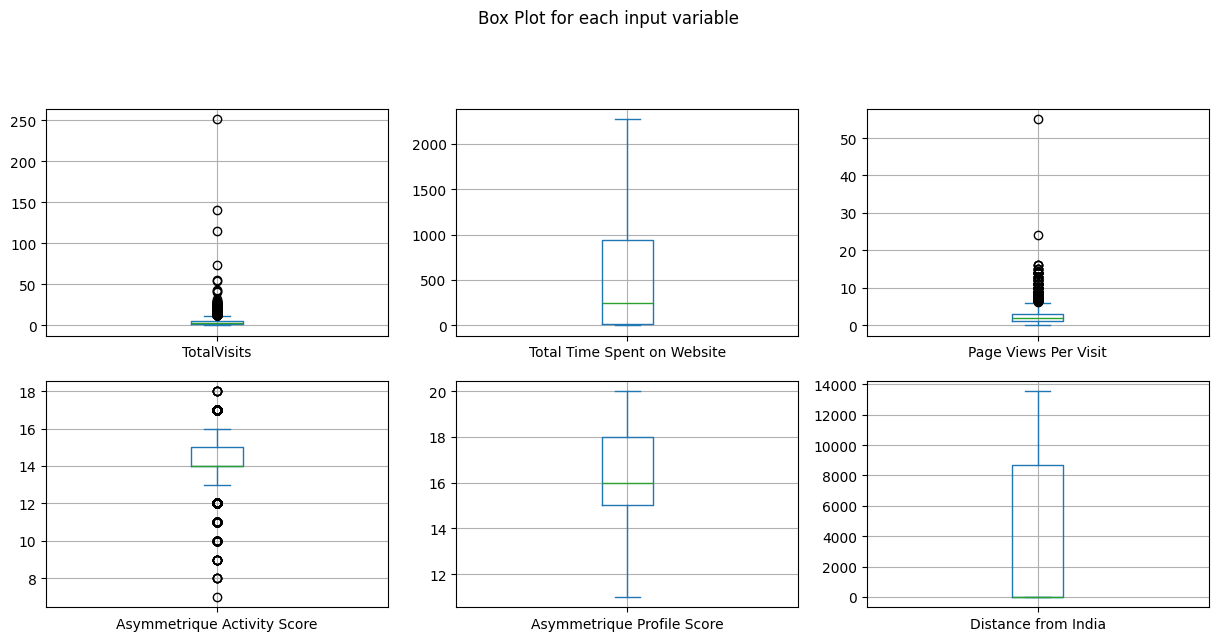

,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score,Distance from India
count,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000,9240.000000
mean,3.445238,487.698268,2.362820,14.306252,16.344883,2514.987505
std,4.854853,548.021466,2.161418,1.386694,1.811395,3954.995424
min,0.000000,0.000000,0.000000,7.000000,11.000000,0.000000
25%,1.000000,12.000000,1.000000,14.000000,15.000000,0.000000
50%,3.000000,248.000000,2.000000,14.000000,16.000000,0.000000
75%,5.000000,936.000000,3.000000,15.000000,18.000000,8657.689542
max,251.000000,2272.000000,55.000000,18.000000,20.000000,13553.690367


In [7]:
df[numerical_columns].plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(15, 10), title='Box Plot for each input variable', grid=True)
plt.show()
df[numerical_columns].describe()

In [8]:
correlation = df[numerical_columns + ['Converted']].corr()

conversion_correlation = correlation['Converted'].drop('Converted')
conversion_correlation = conversion_correlation.sort_values(ascending=False)
correlation_df = pd.DataFrame(conversion_correlation).T

/var/folders/77/x5bdxswj42g15hjcw4d35qk40000gn/T/ipykernel_69883/164722911.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')


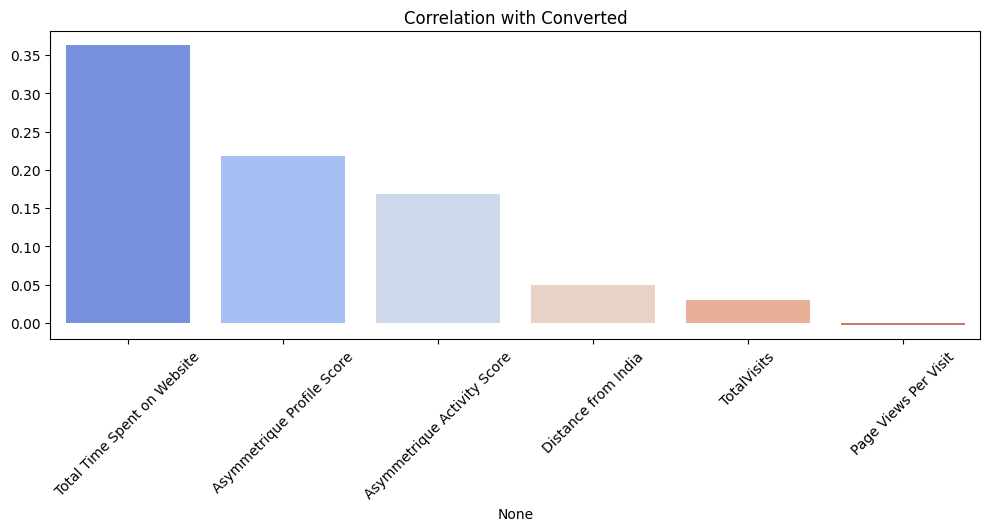

In [9]:
plt.figure(figsize=(12, 4))
ax = sns.barplot(x=conversion_correlation.index, y=conversion_correlation.values, palette='coolwarm', hue=conversion_correlation.index,)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')
plt.title('Correlation with Converted')
plt.show()

# DADOS CATEGÓRICOS

In [10]:
categorical_columns = df.select_dtypes(exclude=[np.number]).columns.tolist()
categorical_columns.remove('Prospect ID')
boolean_columns = ['Do Not Email', 'Do Not Call', 'Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations', 'Receive More Updates About Our Courses', 'Update me on Supply Chain Content', 'Get updates on DM Content', 'I agree to pay the amount through cheque', 'A free copy of Mastering The Interview']
non_boolean_columns = list(set(categorical_columns) - set(boolean_columns))

print(f'Categorical columns shape: {df[categorical_columns].shape}')
df[non_boolean_columns].head()

Categorical columns shape: (9240, 29)


,Lead Profile,Specialization,City,Asymmetrique Activity Index,Lead Origin,Tags,Lead Source,Last Activity,Last Notable Activity,Lead Quality,What matters most to you in choosing a course,Country,Asymmetrique Profile Index,What is your current occupation,How did you hear about X Education
0,Select,Select,Select,02.Medium,API,Interested in other courses,Olark Chat,Page Visited on Website,Modified,Low in Relevance,Better Career Prospects,NaN,02.Medium,Unemployed,Select
1,Select,Select,Select,02.Medium,API,Ringing,Organic Search,Email Opened,Email Opened,NaN,Better Career Prospects,India,02.Medium,Unemployed,Select
2,Potential Lead,Business Administration,Mumbai,02.Medium,Landing Page Submission,Will revert after reading the email,Direct Traffic,Email Opened,Email Opened,Might be,Better Career Prospects,India,01.High,Student,Select
3,Select,Media and Advertising,Mumbai,02.Medium,Landing Page Submission,Ringing,Direct Traffic,Unreachable,Modified,Not Sure,Better Career Prospects,India,01.High,Unemployed,Word Of Mouth
4,Select,Select,Mumbai,02.Medium,Landing Page Submission,Will revert after reading the email,Google,Converted to Lead,Modified,Might be,Better Career Prospects,India,01.High,Unemployed,Other


In [11]:
df[non_boolean_columns].describe()

,Lead Profile,Specialization,City,Asymmetrique Activity Index,Lead Origin,Tags,Lead Source,Last Activity,Last Notable Activity,Lead Quality,What matters most to you in choosing a course,Country,Asymmetrique Profile Index,What is your current occupation,How did you hear about X Education
count,6531,7802,7820,5022,9240,5887,9204,9137,9240,4473,6531,6779,5022,6550,7033
unique,6,19,7,3,5,26,21,17,16,5,3,38,3,6,10
top,Select,Select,Mumbai,02.Medium,Landing Page Submission,Will revert after reading the email,Google,Email Opened,Modified,Might be,Better Career Prospects,India,02.Medium,Unemployed,Select
freq,4146,1942,3222,3839,4886,2072,2868,3437,3407,1560,6528,6492,2788,5600,5043


In [12]:
df[boolean_columns].describe()

,Do Not Email,Do Not Call,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Update me on Supply Chain Content,Get updates on DM Content,I agree to pay the amount through cheque,A free copy of Mastering The Interview
count,9240,9240,9240,9240,9240,9240,9240,9240,9240,9240,9240,9240,9240,9240
unique,2,2,2,1,2,2,2,2,2,1,1,1,1,2
top,No,No,No,No,No,No,No,No,No,No,No,No,No,No
freq,8506,9238,9226,9240,9238,9239,9239,9236,9233,9240,9240,9240,9240,6352


In [13]:
# drop columns that have only one unique value
df = df.drop(['Magazine', 'Receive More Updates About Our Courses', 'Update me on Supply Chain Content', 'Get updates on DM Content', 'I agree to pay the amount through cheque'], axis=1)
categorical_columns = list(set(categorical_columns) - set(['Magazine', 'Receive More Updates About Our Courses', 'Update me on Supply Chain Content', 'Get updates on DM Content', 'I agree to pay the amount through cheque']))
boolean_columns = list(set(boolean_columns) - set(['Magazine', 'Receive More Updates About Our Courses', 'Update me on Supply Chain Content', 'Get updates on DM Content', 'I agree to pay the amount through cheque']))

## Análise de Frequência

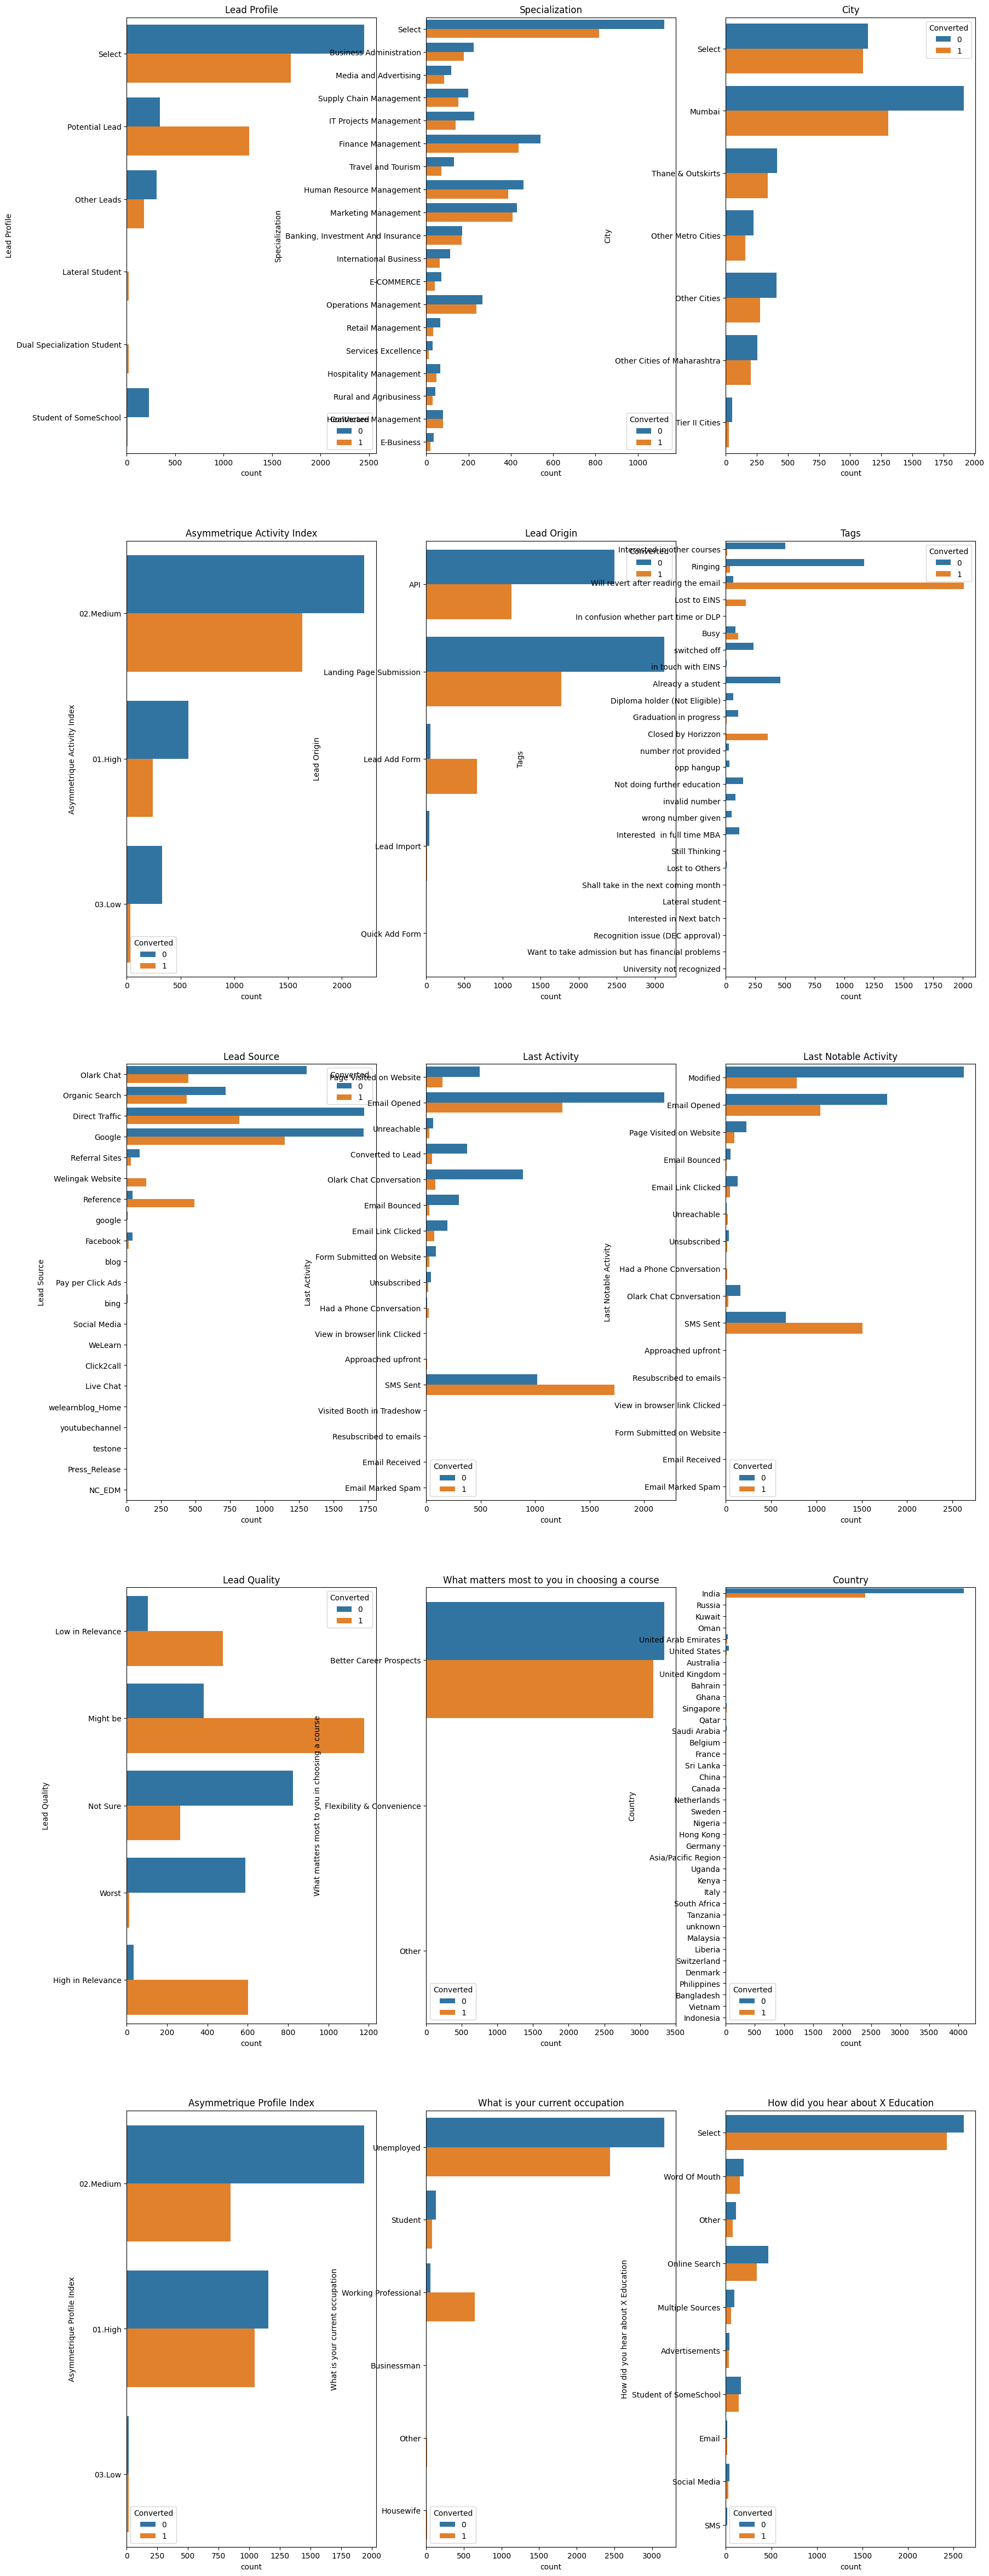

In [14]:
plt.figure(figsize=(20, 60))
for i, column in enumerate(non_boolean_columns):
    plt.subplot(5, 3, i + 1, title=column)
    sns.countplot(y=column, data=df, hue='Converted')

## Análise de Contingência

"A free copy of Mastering The Interview x Converted"
Chi2: 14.47528026391665
P-value: 0.00014201097210552065
Degree of Freedom: 1
Cramer's V: 0.039580156305289556


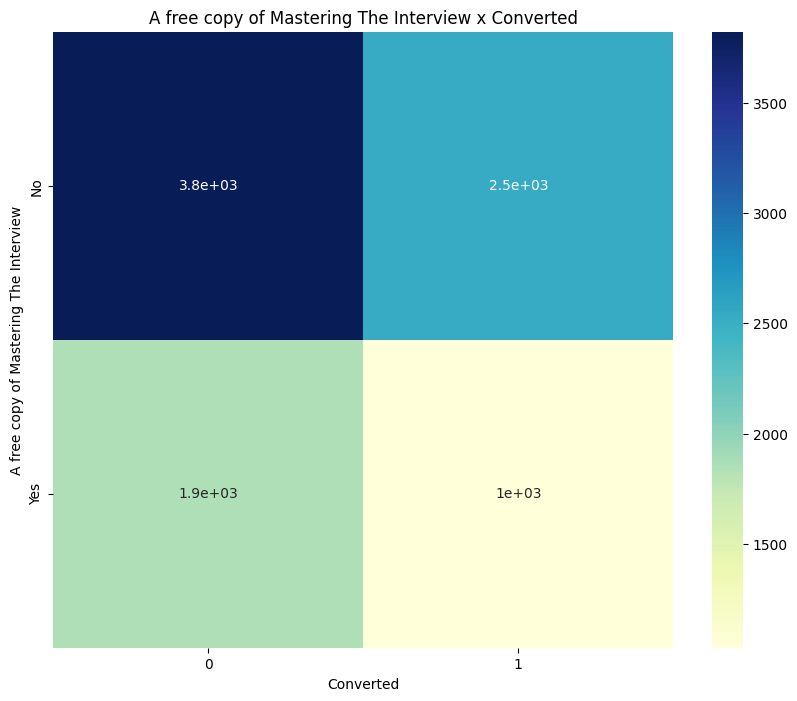

"Search x Converted"
Chi2: 0.0
P-value: 1.0
Degree of Freedom: 1
Cramer's V: 0.0


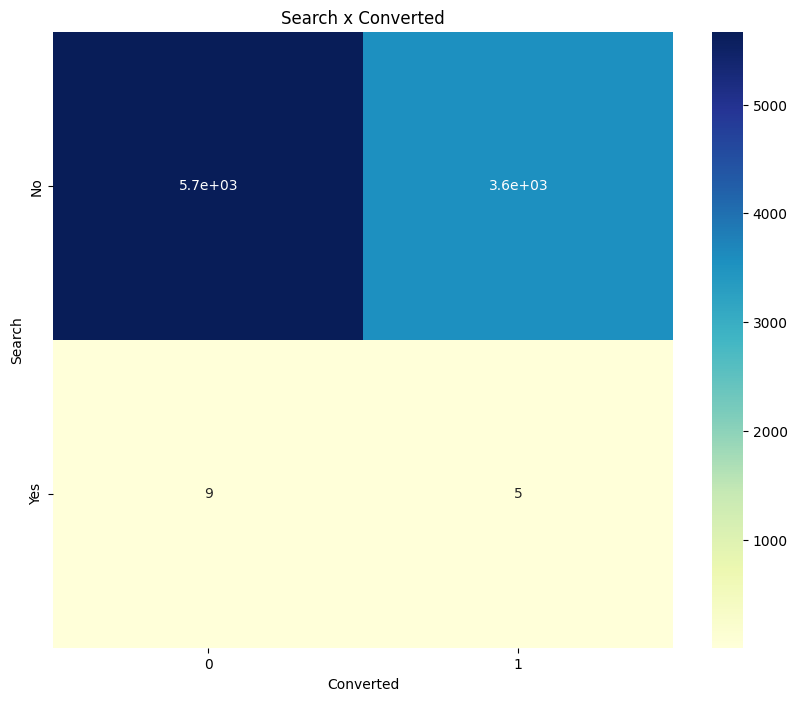

"City x Converted"
Chi2: 46.55637753194113
P-value: 2.293769752363562e-08
Degree of Freedom: 6
Cramer's V: 0.07098287819582498


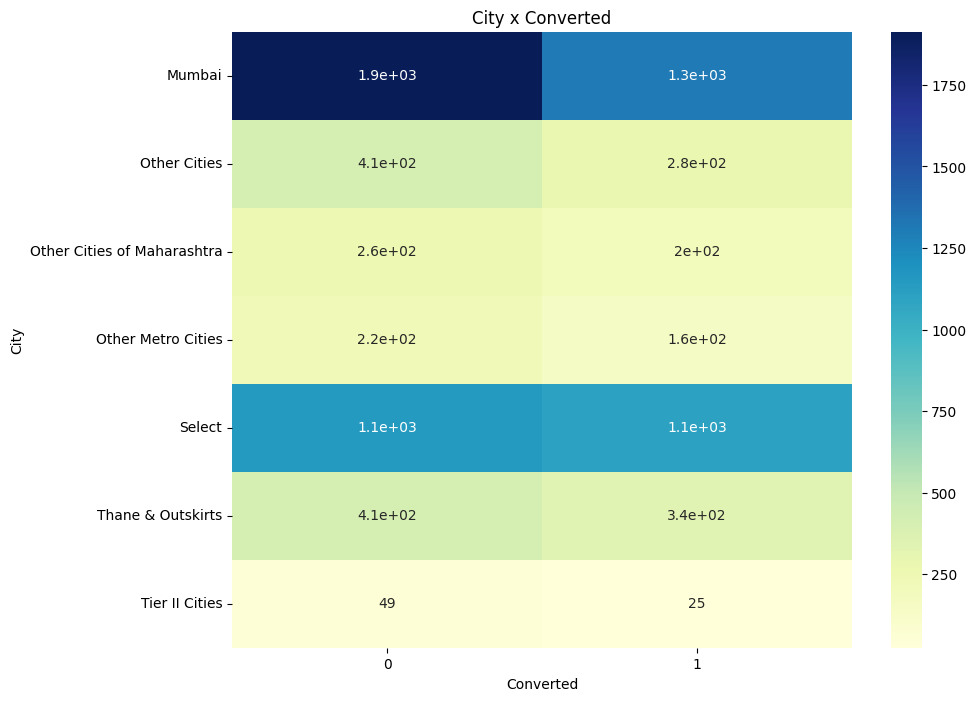

"Lead Origin x Converted"
Chi2: 982.7657814623872
P-value: 1.93831790477878e-211
Degree of Freedom: 4
Cramer's V: 0.32612870627821144


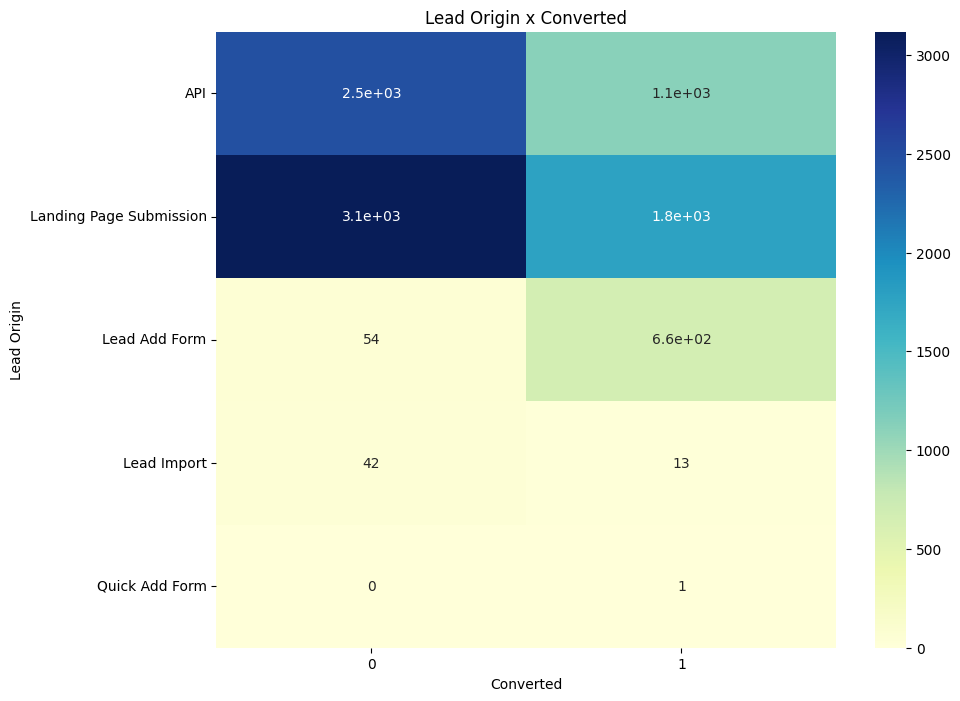

"Do Not Call x Converted"
Chi2: 1.1227477375232788
P-value: 0.2893275634129693
Degree of Freedom: 1
Cramer's V: 0.011023134554334001


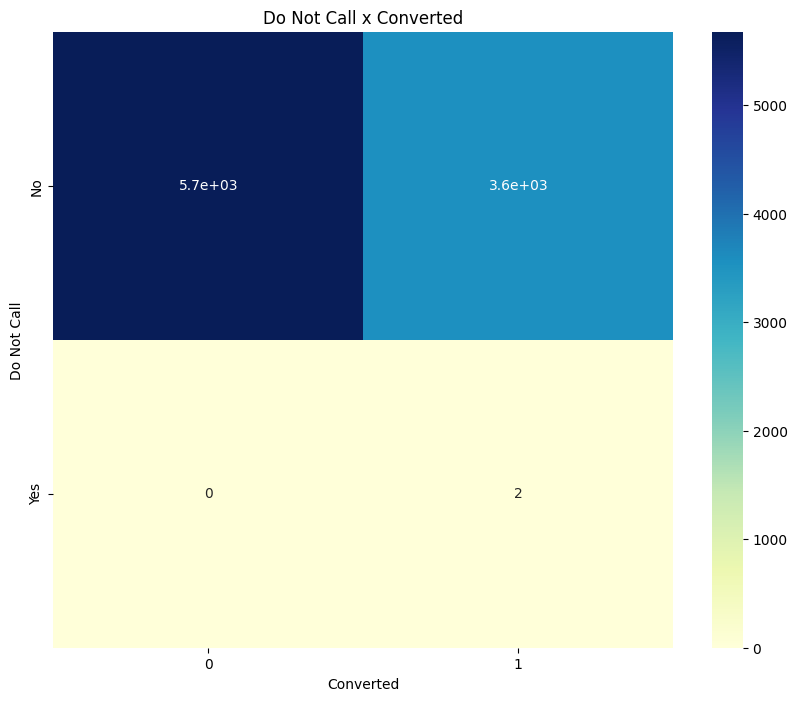

"Lead Source x Converted"
Chi2: 1060.8387235125824
P-value: 4.0834502966012515e-212
Degree of Freedom: 20
Cramer's V: 0.3388353370909458


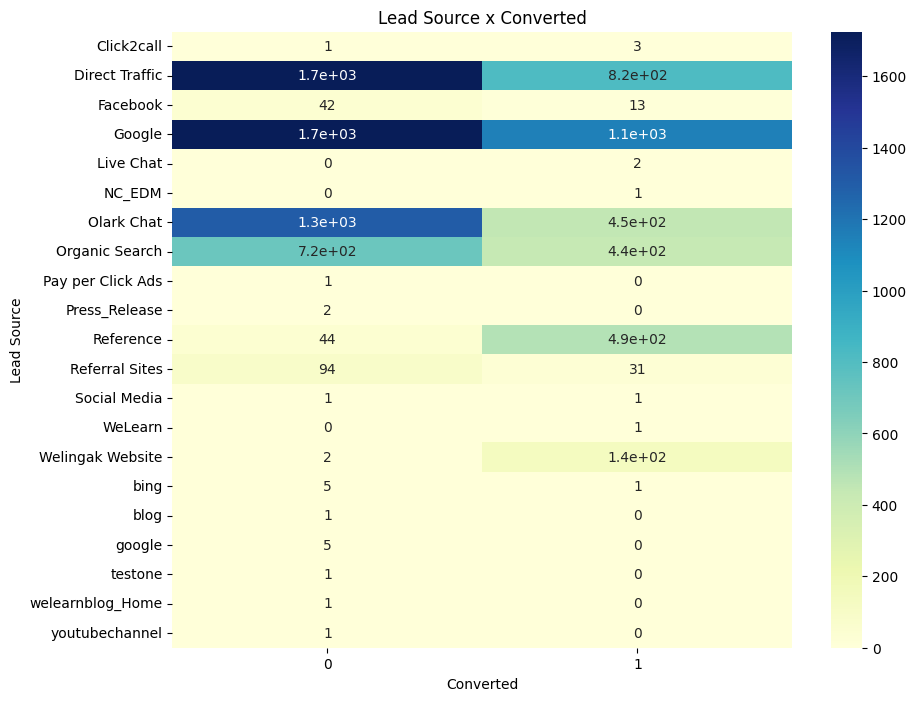

"Last Activity x Converted"
Chi2: 1447.0101611293276
P-value: 1.269441954093108e-298
Degree of Freedom: 16
Cramer's V: 0.3957307560590316


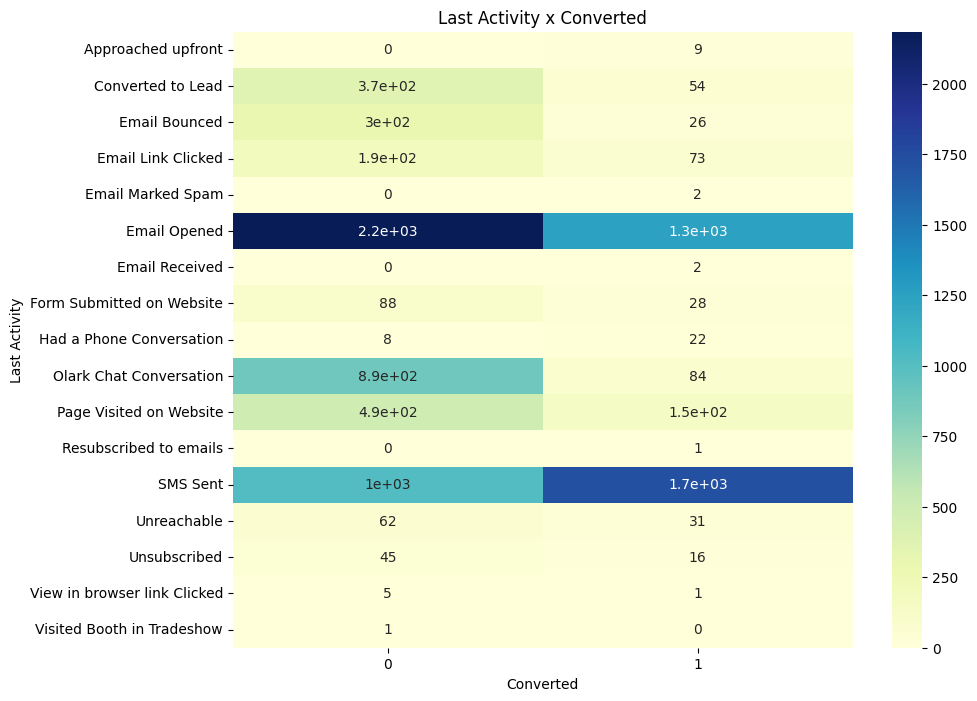

"X Education Forums x Converted"
Chi2: 0.0
P-value: 1.0
Degree of Freedom: 1
Cramer's V: 0.0


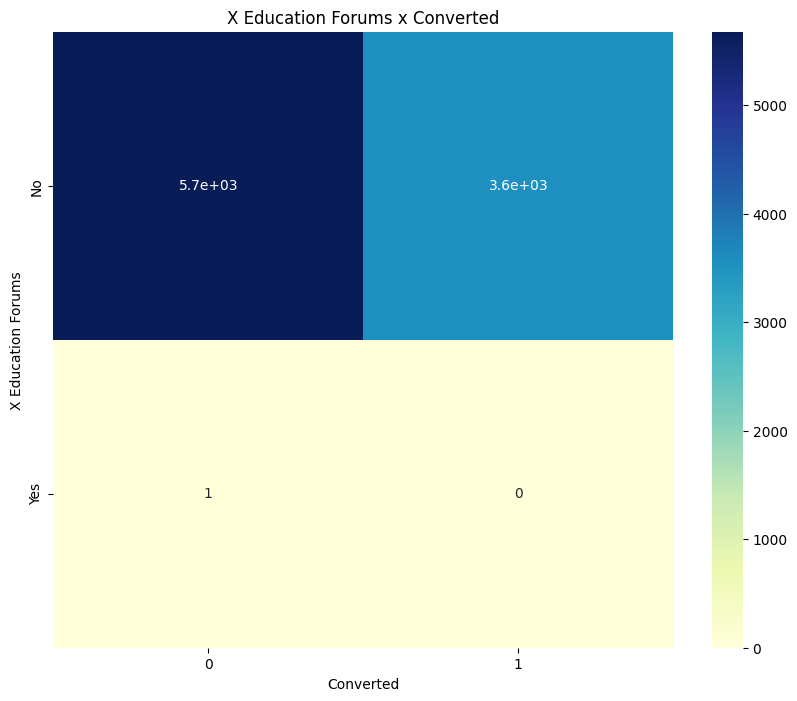

"Do Not Email x Converted"
Chi2: 168.8213277515381
P-value: 1.3384599721779416e-38
Degree of Freedom: 1
Cramer's V: 0.13516917720625762


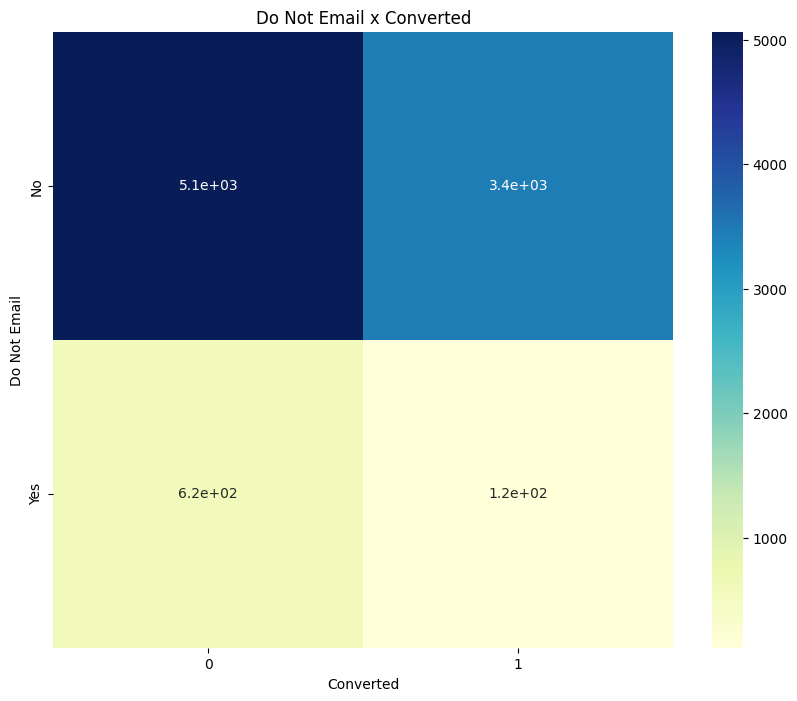

"Through Recommendations x Converted"
Chi2: 1.9605242449062106
P-value: 0.16145726251934528
Degree of Freedom: 1
Cramer's V: 0.014566329276208307


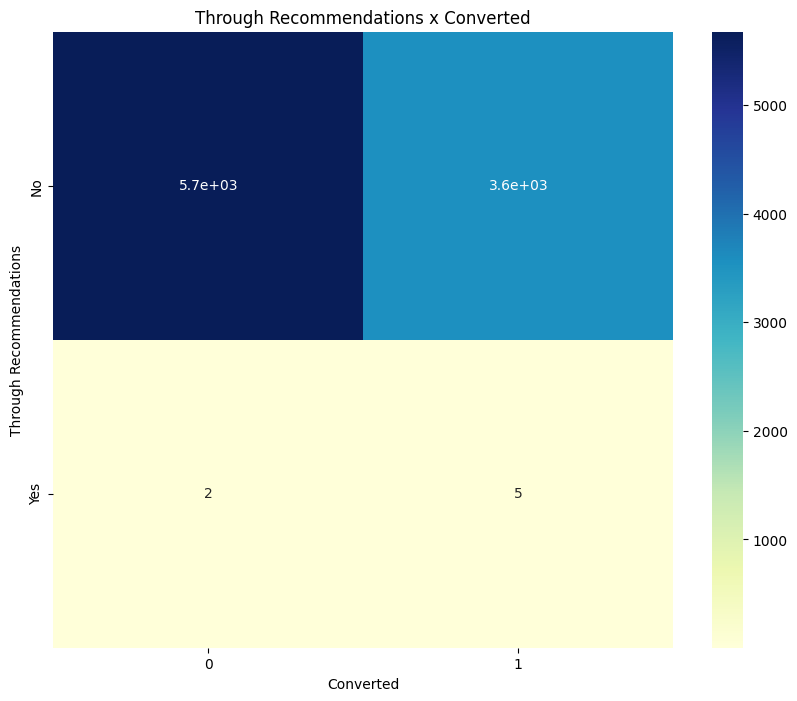

"What matters most to you in choosing a course x Converted"
Chi2: 0.9565637496206916
P-value: 0.6198474529719338
Degree of Freedom: 2
Cramer's V: 0.010174685023474421


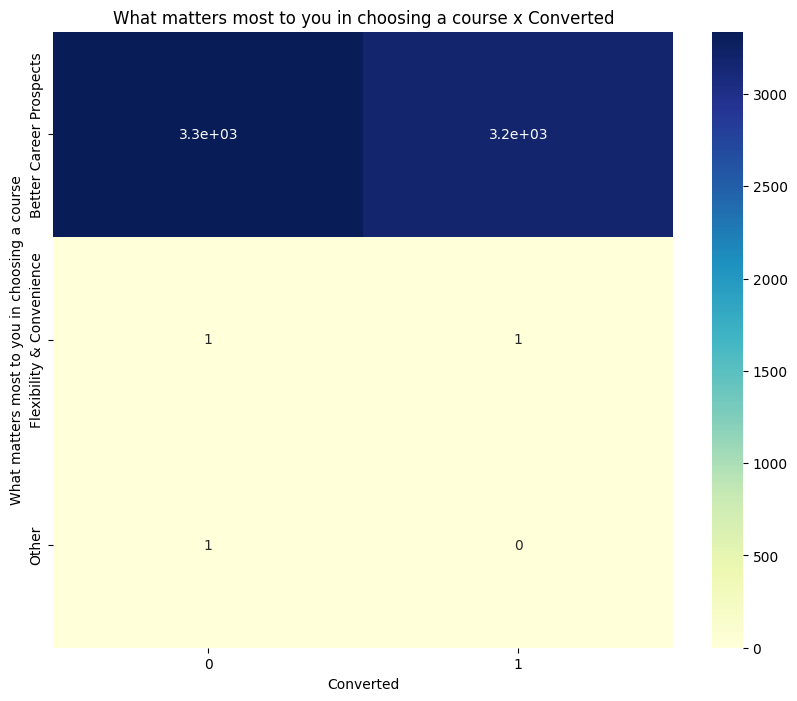

"Digital Advertisement x Converted"
Chi2: 0.0018236717139087017
P-value: 0.9659371166887805
Degree of Freedom: 1
Cramer's V: 0.0004442601361869393


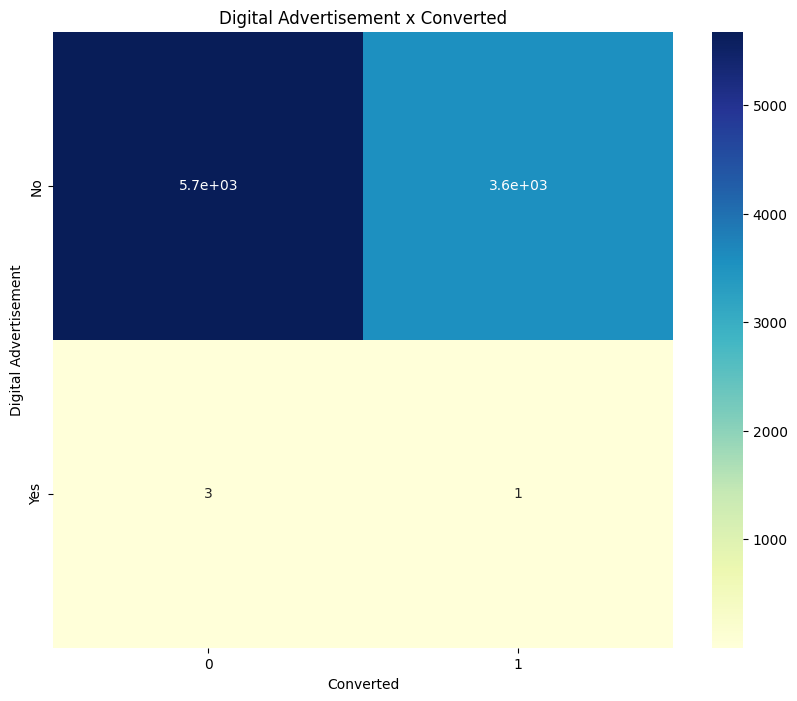

"How did you hear about X Education x Converted"
Chi2: 27.27437965055168
P-value: 0.0012597836614521012
Degree of Freedom: 9
Cramer's V: 0.05433021893434302


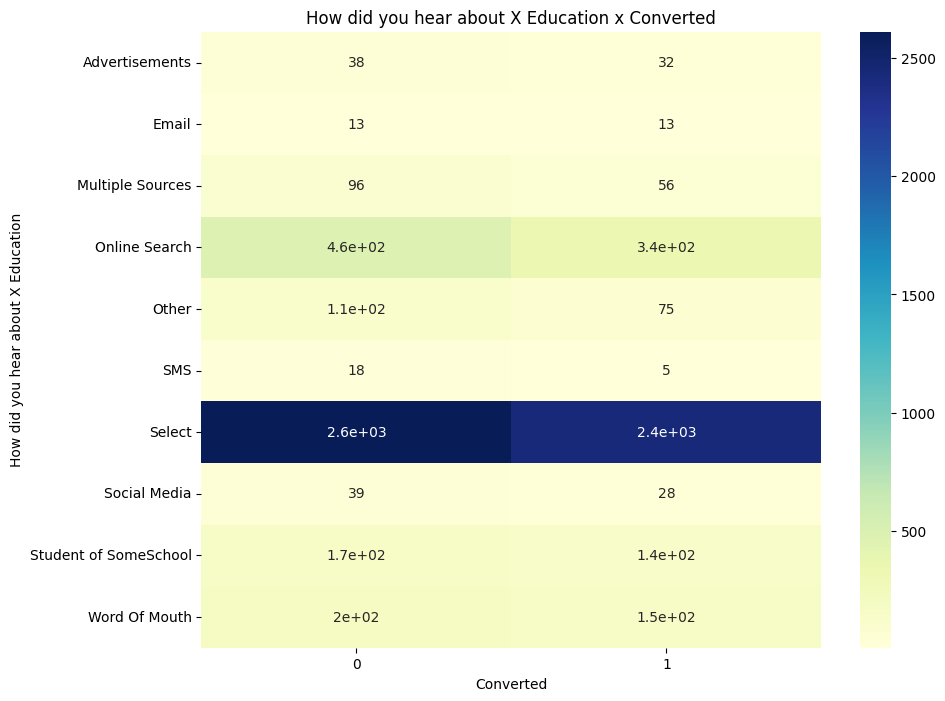

"Lead Profile x Converted"
Chi2: 942.6485466286883
P-value: 1.5638454824905612e-201
Degree of Freedom: 5
Cramer's V: 0.3194029445342212


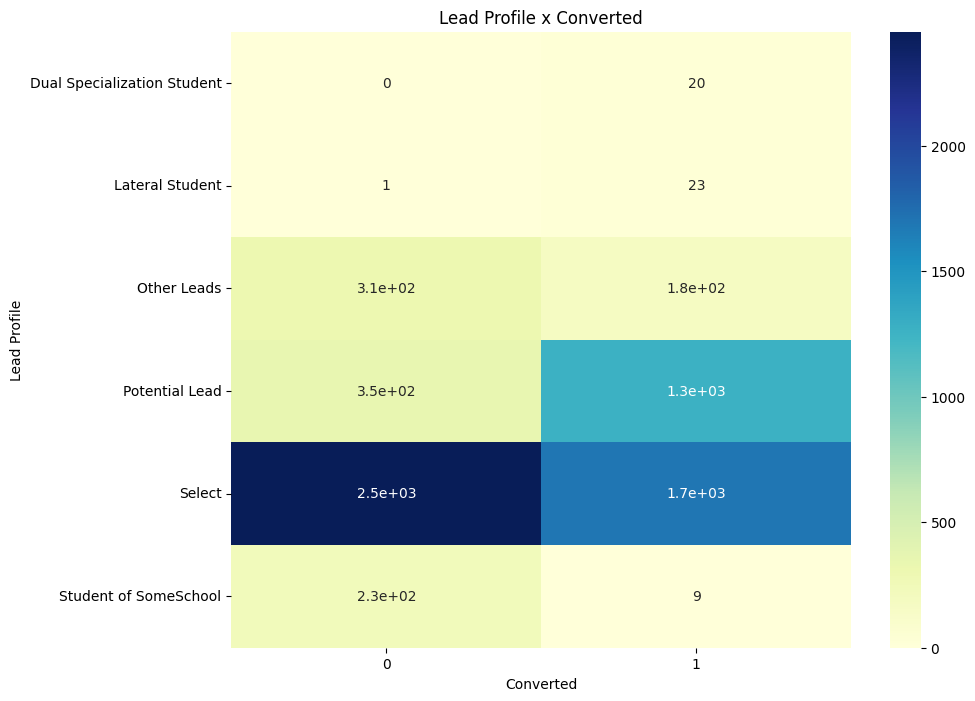

"Specialization x Converted"
Chi2: 48.71317037232546
P-value: 0.00011786276295395725
Degree of Freedom: 18
Cramer's V: 0.07260845774104459


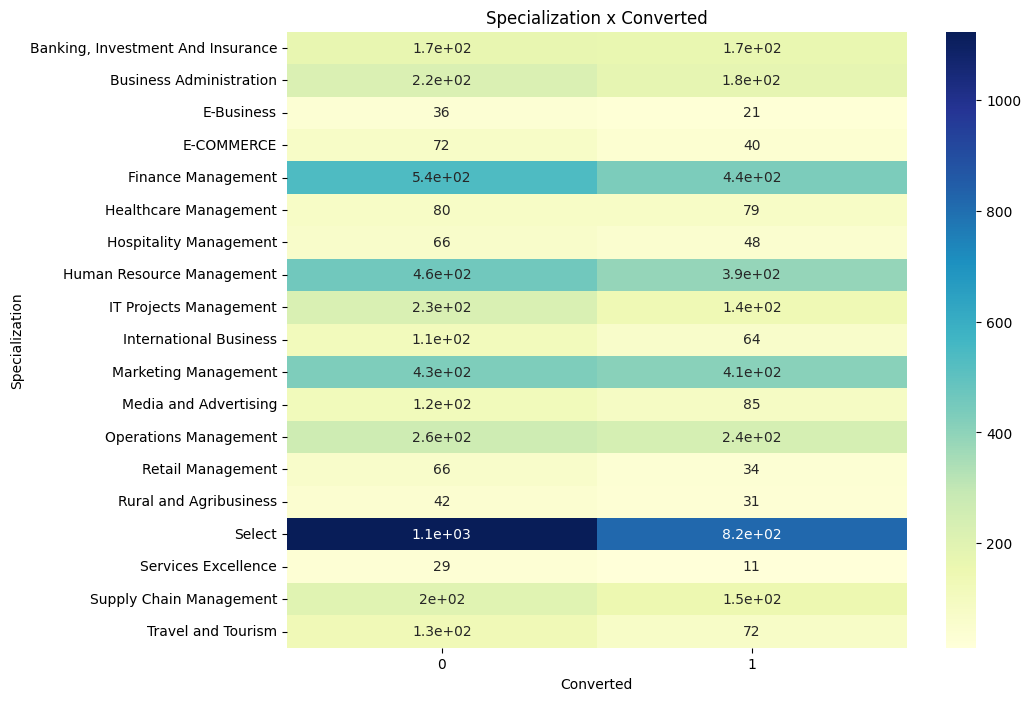

"Newspaper x Converted"
Chi2: 0.0
P-value: 1.0
Degree of Freedom: 1
Cramer's V: 0.0


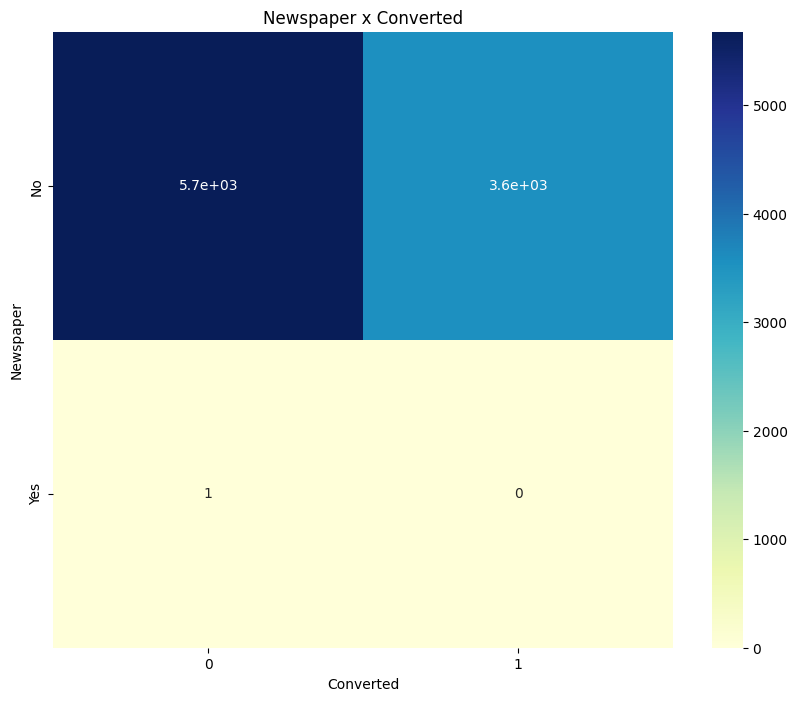

"Asymmetrique Activity Index x Converted"
Chi2: 183.79267438444532
P-value: 1.2300644022164393e-40
Degree of Freedom: 2
Cramer's V: 0.1410353929914001


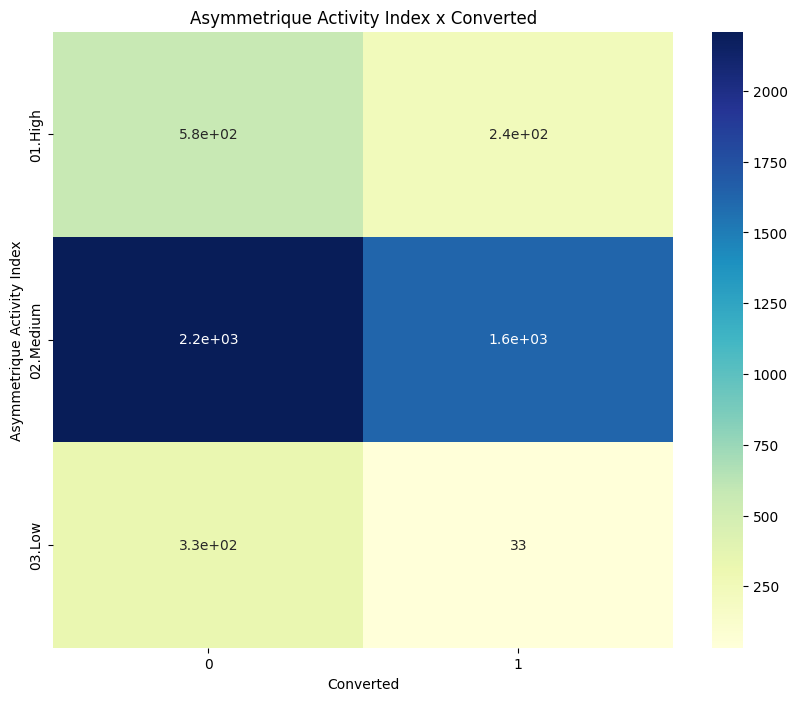

"Newspaper Article x Converted"
Chi2: 0.0
P-value: 1.0
Degree of Freedom: 1
Cramer's V: 0.0


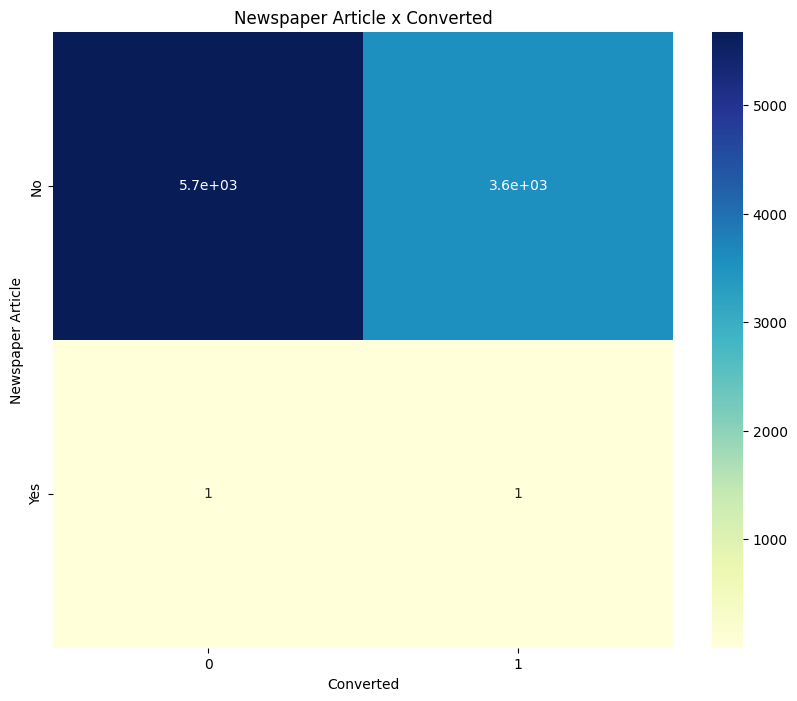

"Tags x Converted"
Chi2: 5130.437188427703
P-value: 0.0
Degree of Freedom: 25
Cramer's V: 0.745145703845703


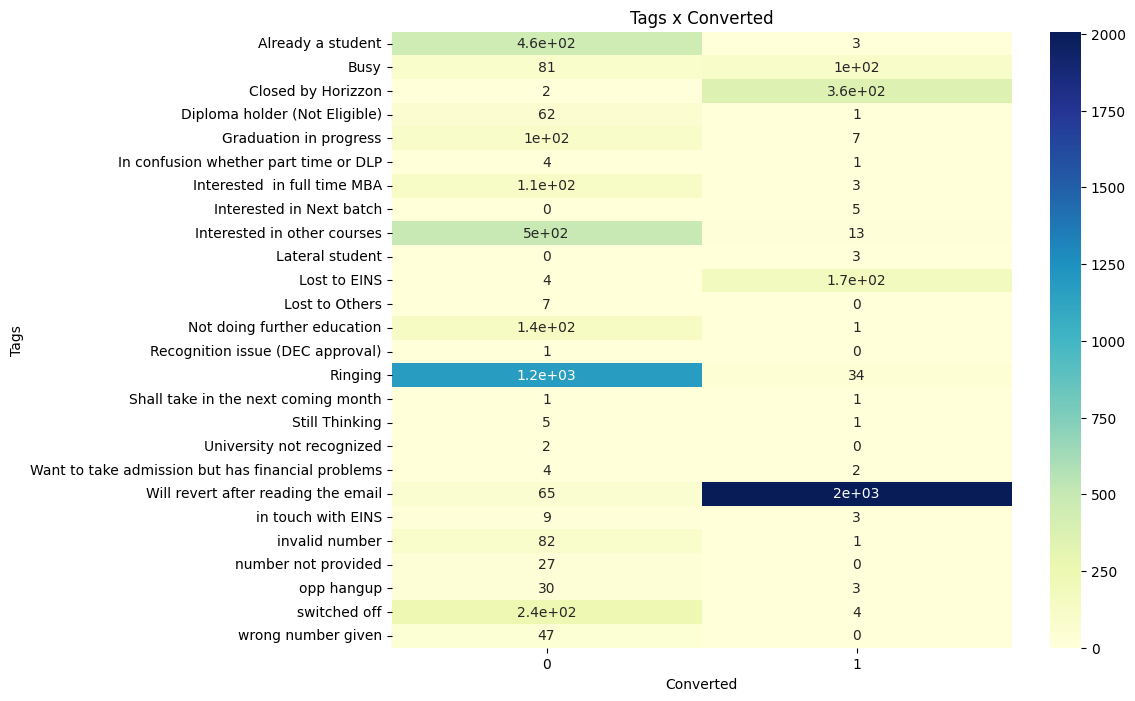

"Last Notable Activity x Converted"
Chi2: 1351.610784640829
P-value: 4.239808596196917e-279
Degree of Freedom: 15
Cramer's V: 0.38246336222699445


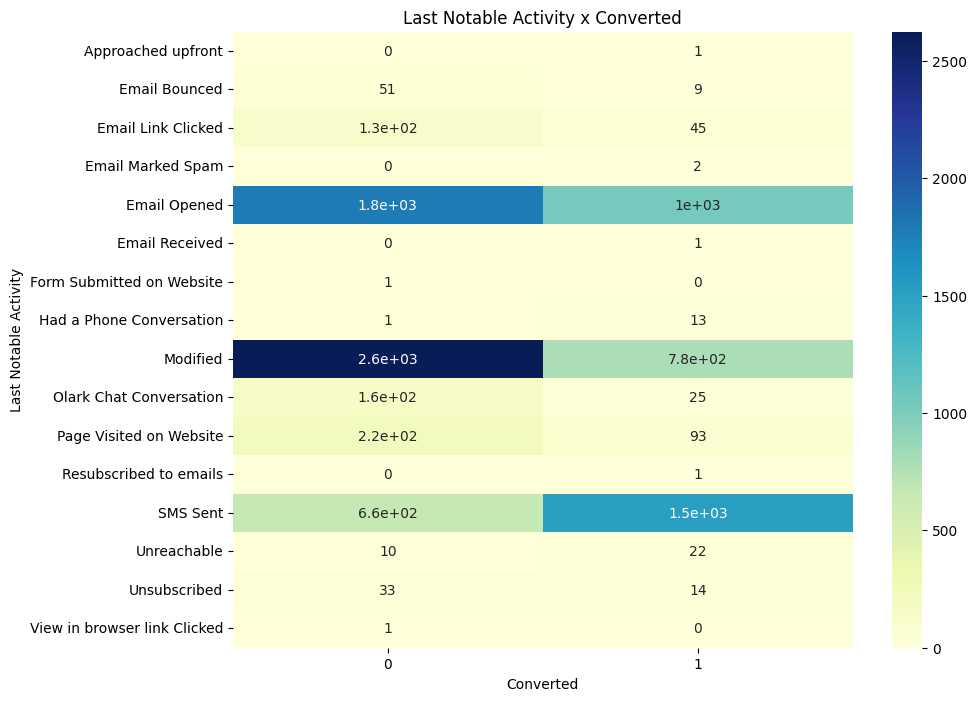

"Lead Quality x Converted"
Chi2: 1948.113557683902
P-value: 0.0
Degree of Freedom: 4
Cramer's V: 0.45916750823108216


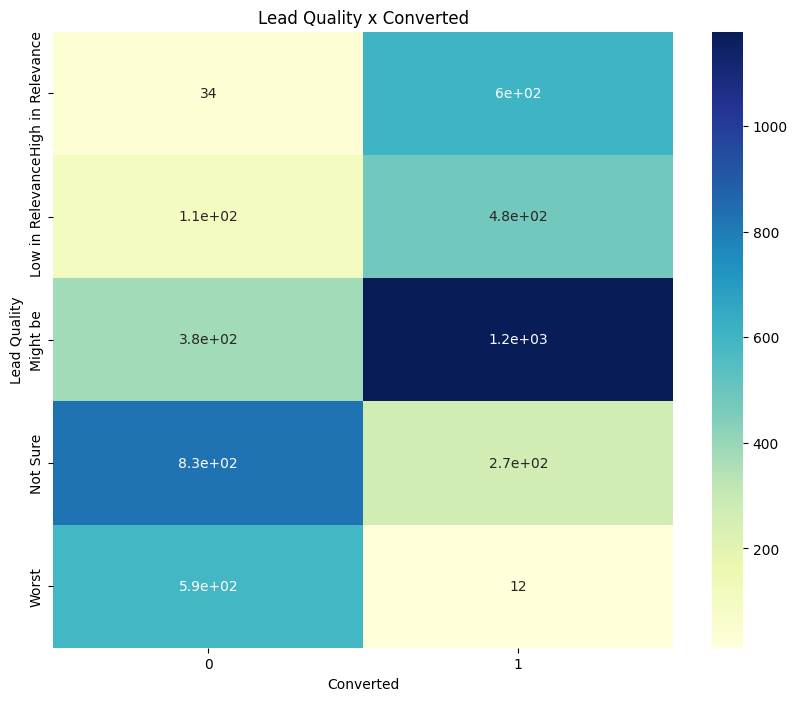

"Country x Converted"
Chi2: 37.30014375800138
P-value: 0.4552761871725188
Degree of Freedom: 37
Cramer's V: 0.06353591185323301


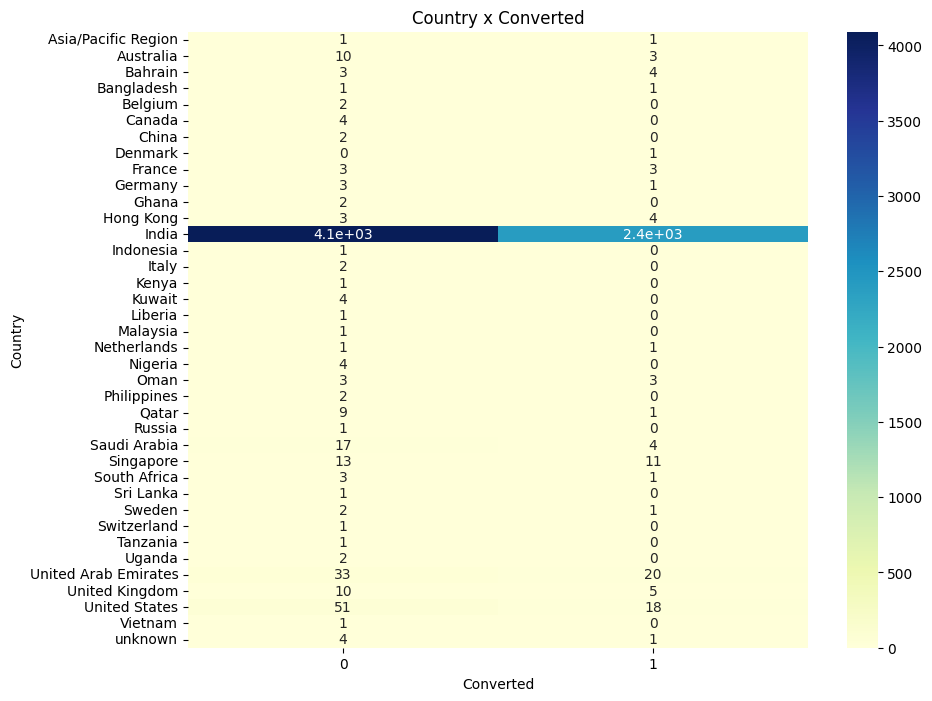

"Asymmetrique Profile Index x Converted"
Chi2: 152.7367485844595
P-value: 6.817677487947714e-34
Degree of Freedom: 2
Cramer's V: 0.12856885760363695


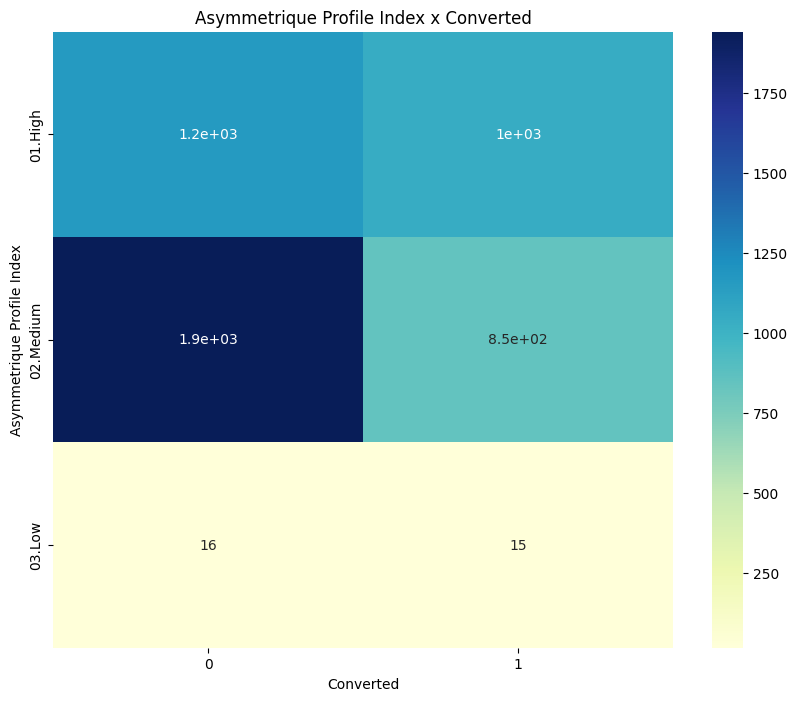

"What is your current occupation x Converted"
Chi2: 603.2538022134563
P-value: 4.0070810643261665e-128
Degree of Freedom: 5
Cramer's V: 0.2555136161376911


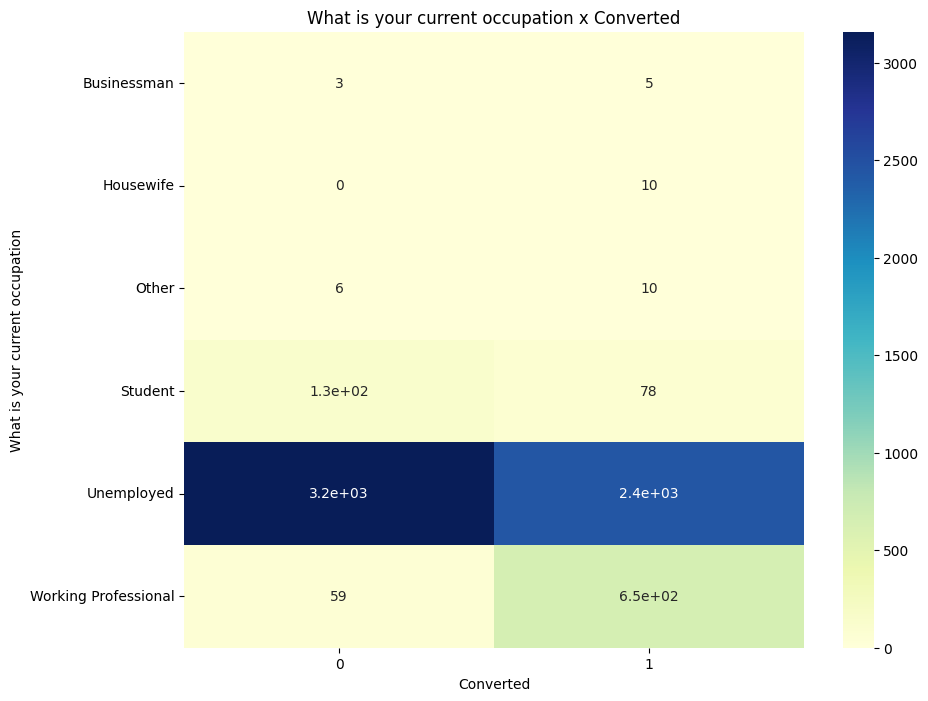

In [15]:
contingency_dict = {}
for i, column in enumerate(categorical_columns):
    contingency_table = pd.crosstab(df[column], df['Converted'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    cramer_v = np.sqrt(chi2 / df.shape[0])
    
    print(f'"{column} x Converted"')
    print(f'Chi2: {chi2}')  
    print(f'P-value: {p}')
    print(f'Degree of Freedom: {dof}')
    print(f'Cramer\'s V: {cramer_v}')
    contingency_dict[column] = cramer_v

    plt.figure(figsize=(10, 8))
    sns.heatmap(contingency_table, annot=True, cmap='YlGnBu')
    plt.title(f'{column} x Converted')
    plt.show()

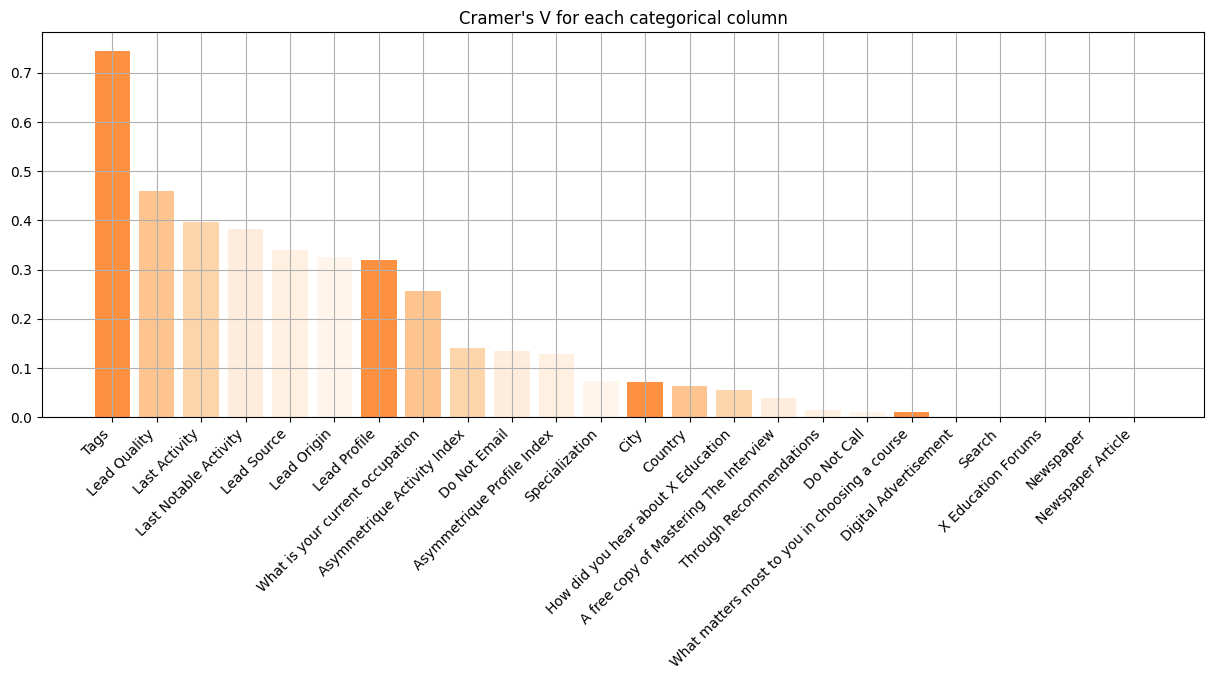

,Total Time Spent on Website,Asymmetrique Profile Score,Asymmetrique Activity Score,Distance from India,TotalVisits,Page Views Per Visit
Converted,0.362483,0.218571,0.167962,0.049329,0.030395,-0.003328


In [16]:
contingency_dict = dict(sorted(contingency_dict.items(), key=lambda item: item[1], reverse=True))
contingency_df = pd.DataFrame(contingency_dict, index=['Converted'])

norm = plt.Normalize(contingency_df.values.min(), contingency_df.values.max())
colors = plt.cm.Oranges(norm(correlation_df.values.flatten()))

fig, ax = plt.subplots(figsize=(15, 5))
bars = ax.bar(contingency_df.columns, contingency_df.values.flatten(), color=colors)

ax.set_title('Cramer\'s V for each categorical column')
ax.grid(True)

plt.xticks(rotation=45, ha='right')

plt.show()
correlation_df.head()


# CORRELAÇÃO ENTRE TODAS AS VARIAVEIS

In [17]:
contingency_df = pd.DataFrame(contingency_dict, index=['Converted'])
correlation_df = pd.concat([correlation_df, contingency_df], axis=1)
correlation_df = correlation_df.T.sort_values(by='Converted', ascending=False).T

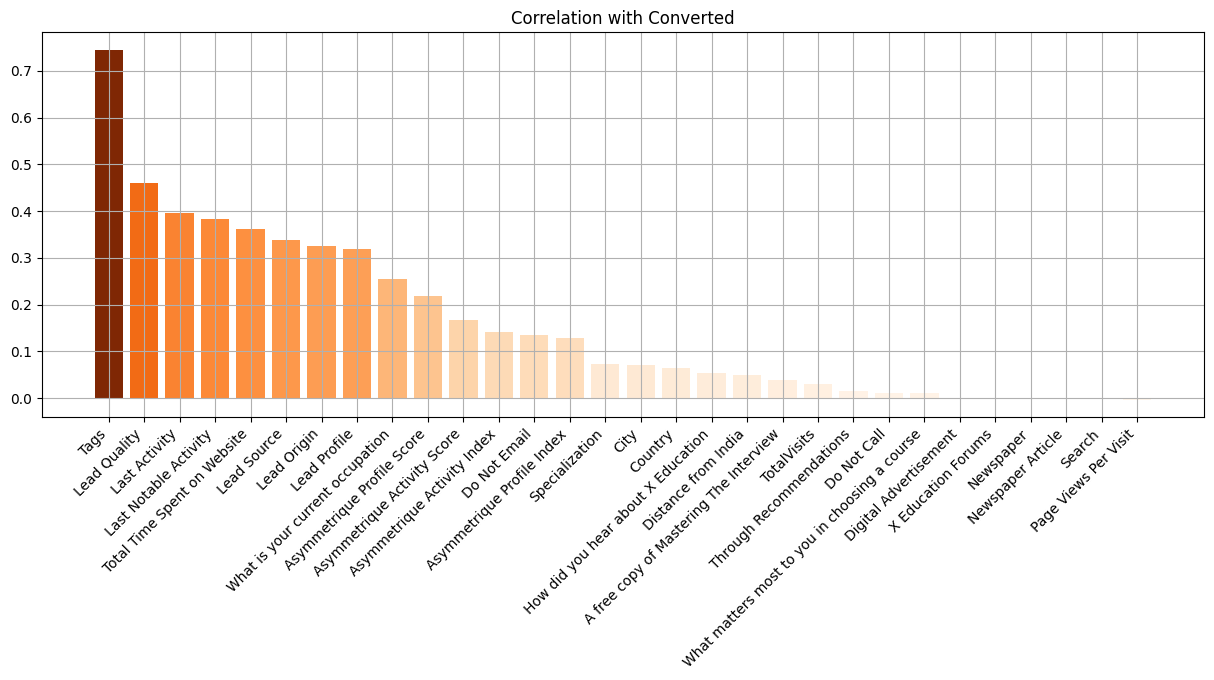

,Tags,Lead Quality,Last Activity,Last Notable Activity,Total Time Spent on Website,Lead Source,Lead Origin,Lead Profile,What is your current occupation,Asymmetrique Profile Score,Asymmetrique Activity Score,Asymmetrique Activity Index,Do Not Email,Asymmetrique Profile Index,Specialization,City,Country,How did you hear about X Education,Distance from India,A free copy of Mastering The Interview,TotalVisits,Through Recommendations,Do Not Call,What matters most to you in choosing a course,Digital Advertisement,X Education Forums,Newspaper,Newspaper Article,Search,Page Views Per Visit
Converted,0.745146,0.459168,0.395731,0.382463,0.362483,0.338835,0.326129,0.319403,0.255514,0.218571,0.167962,0.141035,0.135169,0.128569,0.072608,0.070983,0.063536,0.05433,0.049329,0.03958,0.030395,0.014566,0.011023,0.010175,0.000444,0.0,0.0,0.0,0.0,-0.003328


In [18]:
norm = plt.Normalize(correlation_df.values.min(), correlation_df.values.max())
colors = plt.cm.Oranges(norm(correlation_df.values.flatten()))

fig, ax = plt.subplots(figsize=(15, 5))
bars = ax.bar(correlation_df.columns, correlation_df.values.flatten(), color=colors)

ax.set_title('Correlation with Converted')
ax.grid(True)

plt.xticks(rotation=45, ha='right')

plt.show()
correlation_df.head()

# PREDICTION

In [19]:
df_train = df.sample(frac=0.8, random_state=0)
model = TabularPredictor(label='Converted')
model.fit(df_train)

No path specified. Models will be saved in: "AutogluonModels/ag-20240904_125042"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.5.0: Wed May  1 20:16:51 PDT 2024; root:xnu-10063.121.3~5/RELEASE_ARM64_T8103
CPU Count:          8
Memory Avail:       1.57 GB / 8.00 GB (19.6%)
Disk Space Avail:   31.47 GB / 228.27 GB (13.8%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Defau

In [20]:
df_test = df.drop(df_train.index)
labels = df_test['Converted']
df_test.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Tags,Lead Quality,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,A free copy of Mastering The Interview,Last Notable Activity,Distance from India
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.00,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,Interested in other courses,Low in Relevance,Select,Select,02.Medium,02.Medium,15.0,15.0,No,Modified,8657.689542
19,4512c16a-e96a-4459-b9ec-c7d8fe8c4880,660509,API,Organic Search,No,No,0,3.0,98,3.00,Page Visited on Website,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,Interested in other courses,Worst,Select,Select,02.Medium,02.Medium,14.0,15.0,No,Modified,0.000000
21,fd71ab5b-53b8-4105-9960-efedc44962fa,660478,API,Google,No,No,0,4.0,377,1.33,Page Visited on Website,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,In confusion whether part time or DLP,Worst,Potential Lead,Select,02.Medium,02.Medium,15.0,16.0,No,Modified,0.000000
25,31c326f0-4a9b-43a6-9006-99d3830fbcae,660447,Landing Page Submission,Google,No,No,1,3.0,1068,3.00,Form Submitted on Website,India,Travel and Tourism,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,Busy,Not Sure,Select,Mumbai,02.Medium,02.Medium,14.0,16.0,No,Modified,0.000000
28,8247051c-f838-4a41-b39c-1f0b44c3d5e6,660423,Landing Page Submission,Direct Traffic,No,No,0,5.0,182,5.00,Email Opened,India,Select,Select,Student,Better Career Prospects,No,No,No,No,No,No,switched off,NaN,Select,Mumbai,02.Medium,01.High,13.0,18.0,No,Email Opened,0.000000


In [21]:
predictions = model.predict(df_test.drop('Converted', axis=1).drop('Prospect ID', axis=1))
predictions_prob = model.predict_proba(df_test.drop('Converted', axis=1).drop('Prospect ID', axis=1))

In [22]:
model.evaluate_predictions(y_true=labels, y_pred=predictions, auxiliary_metrics=True)

{'accuracy': 0.9507575757575758,
 'balanced_accuracy': 0.9474532157801774,
 'mcc': 0.8951603157821303,
 'f1': 0.9346733668341709,
 'precision': 0.9353448275862069,
 'recall': 0.9340028694404591}

In [23]:
feature_importance = model.feature_importance(df_test)
feature_importance.head(10)

These features in provided data are not utilized by the predictor and will be ignored: ['Prospect ID', 'Newspaper Article', 'X Education Forums', 'Digital Advertisement']
Computing feature importance via permutation shuffling for 28 features using 1848 rows with 5 shuffle sets...
	14.58s	= Expected runtime (2.92s per shuffle set)
	2.75s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
Tags,0.282143,0.007523,6.061069e-08,5,0.297634,0.266652
What matters most to you in choosing a course,0.042641,0.003891,8.227190e-06,5,0.050652,0.034629
Last Notable Activity,0.020130,0.002578,3.159525e-05,5,0.025438,0.014821
Total Time Spent on Website,0.014935,0.003913,5.173711e-04,5,0.022993,0.006877
Asymmetrique Activity Score,0.012338,0.001401,1.959588e-05,5,0.015222,0.009454
Last Activity,0.009848,0.000593,1.567340e-06,5,0.011069,0.008628
Lead Number,0.004113,0.002853,1.609253e-02,5,0.009987,-0.001762
Distance from India,0.003355,0.001502,3.755562e-03,5,0.006447,0.000263
Page Views Per Visit,0.001732,0.001550,3.342682e-02,5,0.004922,-0.001459
Lead Quality,0.001515,0.001502,4.351780e-02,5,0.004607,-0.001577


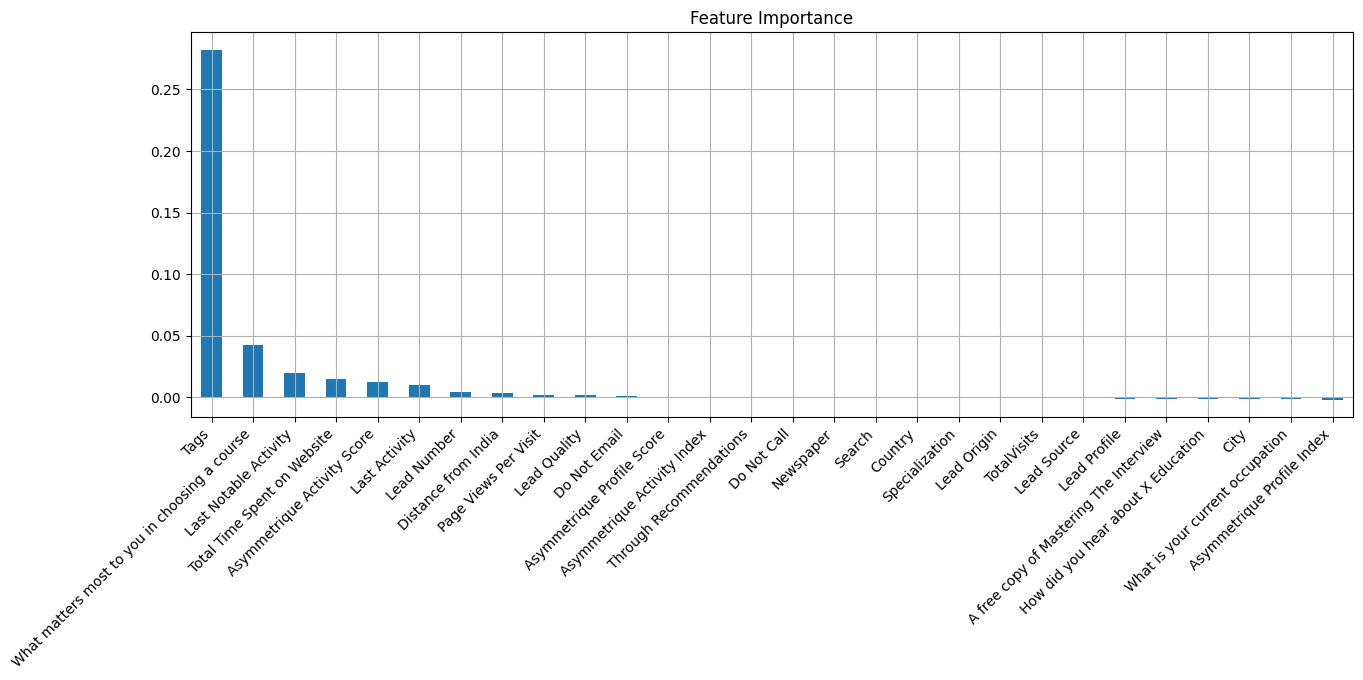

Tags                                             2.821429e-01
What matters most to you in choosing a course    4.264069e-02
Last Notable Activity                            2.012987e-02
Total Time Spent on Website                      1.493506e-02
Asymmetrique Activity Score                      1.233766e-02
Last Activity                                    9.848485e-03
Lead Number                                      4.112554e-03
Distance from India                              3.354978e-03
Page Views Per Visit                             1.731602e-03
Lead Quality                                     1.515152e-03
Do Not Email                                     9.740260e-04
Asymmetrique Profile Score                       2.164502e-04
Asymmetrique Activity Index                      2.220446e-17
Through Recommendations                          0.000000e+00
Do Not Call                                      0.000000e+00
Newspaper                                        0.000000e+00
Search  

In [24]:
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
feature_importance['importance'].plot(kind='bar', title='Feature Importance', figsize=(15, 5), grid=True)
plt.xticks(rotation=45, ha='right')
plt.show()
print(feature_importance['importance'])

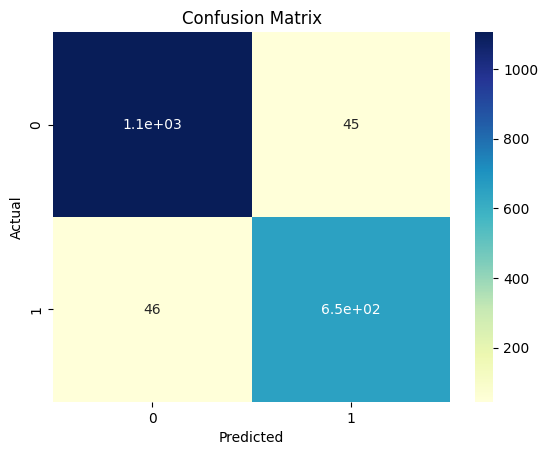

In [25]:
# confusion matrix for the model between labels and predictions
confusion_matrix = pd.crosstab(labels, predictions, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, cmap='YlGnBu')
plt.title('Confusion Matrix')
plt.show()

In [26]:
df_test = df_test[[column for column in df_test.columns if column != 'Converted'] + ['Converted']]

df_test['Conversion Predicted'] = predictions
df_test['Conversion Probabilities'] = predictions_prob[1]
df_test.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Tags,Lead Quality,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,A free copy of Mastering The Interview,Last Notable Activity,Distance from India,Converted,Conversion Predicted,Conversion Probabilities
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0.0,0,0.00,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,Interested in other courses,Low in Relevance,Select,Select,02.Medium,02.Medium,15.0,15.0,No,Modified,8657.689542,0,0,0.051464
19,4512c16a-e96a-4459-b9ec-c7d8fe8c4880,660509,API,Organic Search,No,No,3.0,98,3.00,Page Visited on Website,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,Interested in other courses,Worst,Select,Select,02.Medium,02.Medium,14.0,15.0,No,Modified,0.000000,0,0,0.005300
21,fd71ab5b-53b8-4105-9960-efedc44962fa,660478,API,Google,No,No,4.0,377,1.33,Page Visited on Website,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,In confusion whether part time or DLP,Worst,Potential Lead,Select,02.Medium,02.Medium,15.0,16.0,No,Modified,0.000000,0,0,0.123393
25,31c326f0-4a9b-43a6-9006-99d3830fbcae,660447,Landing Page Submission,Google,No,No,3.0,1068,3.00,Form Submitted on Website,India,Travel and Tourism,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,Busy,Not Sure,Select,Mumbai,02.Medium,02.Medium,14.0,16.0,No,Modified,0.000000,1,1,0.673499
28,8247051c-f838-4a41-b39c-1f0b44c3d5e6,660423,Landing Page Submission,Direct Traffic,No,No,5.0,182,5.00,Email Opened,India,Select,Select,Student,Better Career Prospects,No,No,No,No,No,No,switched off,NaN,Select,Mumbai,02.Medium,01.High,13.0,18.0,No,Email Opened,0.000000,0,0,0.024414


In [27]:
df_test[['Prospect ID', '']]

0     7927b2df-8bba-4d29-b9a2-b6e0beafe620
19    4512c16a-e96a-4459-b9ec-c7d8fe8c4880
21    fd71ab5b-53b8-4105-9960-efedc44962fa
25    31c326f0-4a9b-43a6-9006-99d3830fbcae
28    8247051c-f838-4a41-b39c-1f0b44c3d5e6
Name: Prospect ID, dtype: object